In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
from scipy.special import digamma, gamma, logsumexp, expit
from scipy.stats import norm, gamma, bernoulli
from scipy import stats
from tqdm.notebook import tqdm
import torch
import torch.distributions as dist
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [86]:
%config InlineBackend.figure_format = 'retina'
sns.set()

# Plannar flows

In [87]:
def safe_log(z):
    return torch.log(z + 1e-7)

In [88]:
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length):
        super().__init__()

        self.transforms = nn.Sequential(*(
            PlanarFlow(dim) for _ in range(flow_length)
        ))

        self.log_jacobians = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms
        ))
        
        self.mu = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        self.log_var = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        
        self.dim = dim
        self.flow_length = flow_length

    def forward(self, batch_size):
        
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn((batch_size, self.dim))  
        z0 = self.mu + eps * std
        
        z=z0

        log_jacobians = torch.zeros((self.flow_length, batch_size, 1))

        for i, transform, log_jacobian in zip(range(self.flow_length), self.transforms, self.log_jacobians):
            log_jacobians[i] = log_jacobian(z)
            z = transform(z)

        zk = z

        return z0, z, log_jacobians, self.mu, self.log_var


class PlanarFlow(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.tanh = nn.Tanh()

        self.reset_parameters()

    def reset_parameters(self):

        self.weight.data.uniform_(-0.01, 0.01)
        self.scale.data.uniform_(-0.01, 0.01)
        self.bias.data.uniform_(-0.01, 0.01)

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)


class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())

In [89]:
class DoubleFlow(nn.Module):

    def __init__(self, dim, flow_length):
        super().__init__()

        self.flows = nn.Sequential(*(NormalizingFlow(d, flow_length=flow_length) for d in dim))

    def forward(self, batch_size):
        
        out = ()
        for f in self.flows:
            out += f(batch_size)

        return out

In [90]:
class FreeEnergyBound(nn.Module):

    def __init__(self, x, y, r, u, w, n_u, n_w):
        super().__init__()
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y) 
        self.r = torch.from_numpy(r) 
        self.u = u
        self.w = w
        self.n_u = n_u
        self.n_w = n_w

    def forward(self, flow, batch_size):
        
        z0_Z, zk_Z, log_jacobians_Z, mu_Z, log_var_Z, \
            z0_θ, zk_θ, log_jacobians_θ, mu_θ, log_var_θ  = flow(batch_size)

        ln_q0_Z = dist.Normal(mu_Z, torch.exp(0.5*log_var_Z)).log_prob(z0_Z).sum()
        ln_q0_θ = dist.Normal(mu_θ, torch.exp(0.5*log_var_θ)).log_prob(z0_θ).sum()

        sum_lj_Z = log_jacobians_Z.sum()
        sum_lj_θ = log_jacobians_θ.sum()
        
        Zu1 = zk_Z[:, :self.n_u].T
        Zw1 = zk_Z[:, self.n_u:self.n_w+n_u].T

        Zu2 = zk_Z[:, self.n_w+self.n_u:self.n_w+self.n_u*2].T
        Zw2 = zk_Z[:, self.n_w+self.n_u*2:].T

        mu1, log_var_u1, log_var_w1 = zk_θ[:, :3].T
        mu2, log_var_u2, log_var_w2 = zk_θ[:, 3:].T

        Z1 = Zu1[self.u] + Zw1[self.w]
        Z2 = Zu2[self.u] + Zw2[self.w]

        a = torch.exp(Z1)
        b = torch.sigmoid(Z2)

        log_p = -a*self.x*(1-b)**self.r
        
        ll = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(self.y).sum()

        ll_Zu1 = dist.Normal(mu1, torch.exp(0.5*log_var_u1)).log_prob(Zu1).sum()
        ll_Zw1 = dist.Normal(mu1, torch.exp(0.5*log_var_w1)).log_prob(Zw1).sum()

        ll_Zu2 = dist.Normal(mu2, torch.exp(0.5*log_var_u2)).log_prob(Zu2).sum()
        ll_Zw2 = dist.Normal(mu2, torch.exp(0.5*log_var_w2)).log_prob(Zw2).sum()
        
        to_min = (ln_q0_Z + ln_q0_θ - sum_lj_Z - sum_lj_θ
                  - ll - ll_Zu1 - ll_Zu2 - ll_Zw1 - ll_Zw2) / batch_size
        return to_min

In [91]:
def train(x, y, r, u, w, n_u, n_w, 
          flow_length=16, epochs=10000, initial_lr=0.01, lr_decay=0.999, batch_size=40):
    
    flow = DoubleFlow(dim=((n_u+n_w)*2, 6), flow_length=flow_length)
    bound = FreeEnergyBound(x=x, y=y, r=r, u=u, w=w, n_u=n_u, n_w=n_w)
    optimizer = optim.RMSprop(flow.parameters(), lr=initial_lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
    
    hist_loss = np.zeros(epochs)
    
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):

            optimizer.zero_grad()
            loss = bound(flow=flow, batch_size=batch_size)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            hist_loss[i] = loss.item()
            
            if i % 50 == 0 and i > 0:
                pbar.set_postfix({'loss': np.mean(hist_loss[i-50:i])})
            pbar.update()
            
    return flow, hist_loss

# Figures

In [92]:
def plot_loss(hist_loss, zoom_start=1000):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axes[0]
    ax.plot(hist_loss)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    ax = axes[1]
    ax.plot(np.arange(len(hist_loss))[-zoom_start:], hist_loss[-zoom_start:])
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    fig.tight_layout();

In [93]:
def plot_posterior(flow, batch_size=1000, truth=None):   
    
    z0_Z, zk_Z, log_jacobians_Z, mu_Z, log_var_Z, \
        z0_θ, zk_θ, log_jacobians_θ, mu_θ, log_var_θ  = flow(batch_size)

    mu1, log_var_u1, log_var_w1 = zk_θ.data[:, :3].T
    mu2, log_var_u2, log_var_w2 = zk_θ.data[:, 3:].T
    
    fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

    alpha = 0.1

    ax = axes[0, 0]
    ax.set_title(r"$\alpha$ - $U$")
    ax.scatter(mu1, log_var_u1, 
               color='C0', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    
    if truth is not None:
        ax.scatter(truth['mu'][0]/2, np.log(truth['sg_u'][0]**2), 
                   edgecolors='C3', alpha=1, 
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][0]/2, np.log(truth['sg_u_smp'][0]**2), 
                   facecolors='none', edgecolors='C1', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[1, 0]
    ax.set_title(r"$\alpha$ - $W$")
    ax.scatter(mu1, log_var_w1, 
               color='C0', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][0]/2, np.log(truth['sg_w'][0]**2), 
                   edgecolors='C3', 
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][0]/2, np.log(truth['sg_w_smp'][0]**2), 
                   facecolors='none', edgecolors='C1', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[0, 1]
    ax.set_title(r"$\beta$ - $U$")
    ax.scatter(mu2, log_var_u2, 
               color='C1', alpha=alpha, label=r"$\theta \sim Q(\theta)$")

    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][1]/2, np.log(truth['sg_u'][1]**2), 
                   edgecolors='C3',
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][1]/2, np.log(truth['sg_u_smp'][1]**2), 
                   facecolors='none', edgecolors='C1', s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[1, 1]
    ax.set_title(r"$\beta$ - $W$")
    ax.scatter(mu2, log_var_w2, 
               color='C1', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][1]/2, np.log(truth['sg_w'][1]**2), 
                   edgecolors='C3', alpha=1, 
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][1]/2, np.log(truth['sg_w_smp'][1]**2), 
                   facecolors='none', edgecolors='C1', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    fig.tight_layout()

# Run on artificial data

In [94]:
# Seed
np.random.seed(0)

sg_u = 0.5, 0.2
sg_w = 1.0, 0.4
mu = -4., -2.

n_u = 20
n_w = 20
n_obs_per_wu = 100
n_obs = n_obs_per_wu*n_u*n_w

u = np.concatenate([np.zeros(n_obs_per_wu*n_w, dtype=int) + i for i in range(n_u)])
w = np.tile(np.concatenate([np.zeros(n_obs_per_wu, dtype=int) + i for i in range(n_w)]), n_u)

r = np.zeros(n_obs)
r[:] = np.tile(np.concatenate([np.arange(1, n_obs_per_wu+1, dtype=int) for _ in range(n_w)]), n_u)

Zu = np.random.normal(np.zeros(2), sg_u, size=(n_u, 2)) 
Zw = np.random.normal(np.zeros(2), sg_w, size=(n_w, 2)) 

x = np.random.uniform(5, 1000, size=n_obs)
rd = np.random.random(size=n_obs)

y = np.zeros(shape=n_obs)

Z = mu + Zu[u] + Zw[w]

a = np.exp(Z[:, 0])
b = expit(Z[:, 1])
neg_rate = - a * x * (1-b)**r
p = np.exp(neg_rate)
y[:] = p > rd

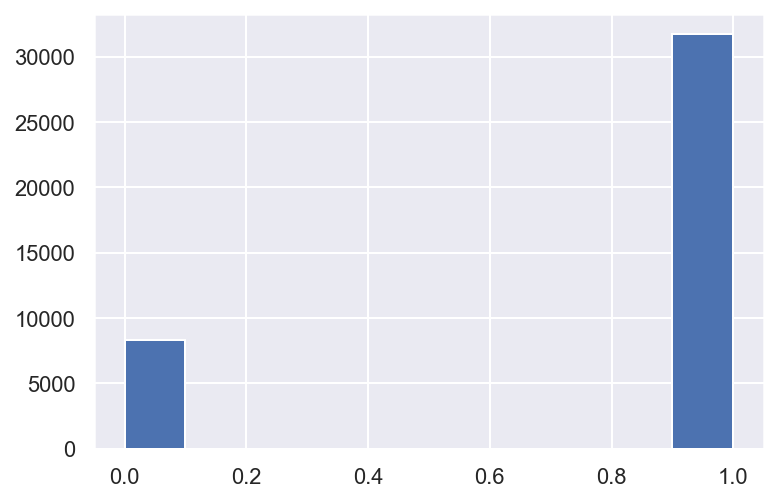

In [95]:
plt.hist(y);

In [96]:
data = {'n_u': n_u, 'n_w': n_w, 'n_obs': n_obs,
        'u': u, 'w': w, 
        'x': x.reshape(-1, 1), 'r': r.reshape(-1, 1),
        'y': y.reshape(-1, 1)}

In [97]:
sg_u_smp = np.std(Zu, axis=0)
sg_w_smp = np.std(Zw, axis=0)
mu_smp = np.mean(Z, axis=0)
print(f"n obs: {n_obs}")
print(f"sg_u: theoretical={sg_u}; data={sg_u_smp}")
print(f"sg_w theoretical={sg_w}; data={sg_w_smp}")
print(f"mu: theoretical={mu}; data={mu_smp}")

n obs: 40000
sg_u: theoretical=(0.5, 0.2); data=[0.54099092 0.2003145 ]
sg_w theoretical=(1.0, 0.4); data=[0.75688435 0.33018865]
mu: theoretical=(-4.0, -2.0); data=[-4.28114954 -2.06142483]


In [98]:
flow, hist_loss = train(x=data['x'], y=data['y'], 
                        r=data['r'], u=data['u'], w=data['w'],
                        n_u=data['n_u'], n_w=data['n_w'],
                        batch_size=40,
                        epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
plot_loss(hist_loss, zoom_start=500)

In [ ]:
plot_posterior(flow, truth={'mu': mu, 'sg_u': sg_u, 'sg_w': sg_w,
                            'mu_smp': mu_smp, 'sg_u_smp': sg_u_smp, 'sg_w_smp': sg_w_smp},
              batch_size=2000)

# Run on experimental data

In [93]:
df = pd.read_csv("../data_full.csv", index_col=0)
df.drop(df[(df.domain != "active.fi") | (df.n_session_done != 14)].index, inplace=True)
df["ts_display"] = pd.to_datetime(df["ts_display"])  # str to datetime
df["ts_reply"] = pd.to_datetime(df["ts_reply"]) 
# Convert timestamps into seconds
beginning_history = pd.Timestamp("1970-01-01", tz="UTC")
df["timestamp"] = (df["ts_reply"] - beginning_history).dt.total_seconds().values
# Copy actual item ID
df["item_id"] = df.item
for i, i_id in enumerate(df.item_id.unique()): 
    df.loc[df.item_id == i_id, 'item'] = i
df

,user,domain,condition,item,success,teacher_md,learner_md,psy_md,session,is_eval,ts_display,ts_reply,n_session_done,timestamp,item_id
49739,goldfish@active.fi,active.fi,ThresholdCondition,0,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:37.666000+00:00,2020-09-30 17:51:41.042000+00:00,14,1.601488e+09,1506
49740,goldfish@active.fi,active.fi,ThresholdCondition,1,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:42.081000+00:00,2020-09-30 17:51:43.910000+00:00,14,1.601488e+09,190
49741,goldfish@active.fi,active.fi,ThresholdCondition,2,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:44.980000+00:00,2020-09-30 17:51:46.413000+00:00,14,1.601488e+09,1000
49742,goldfish@active.fi,active.fi,ThresholdCondition,0,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:47.476000+00:00,2020-09-30 17:51:50.206000+00:00,14,1.601488e+09,1506
49743,goldfish@active.fi,active.fi,ThresholdCondition,1,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:51.245000+00:00,2020-09-30 17:51:53.477000+00:00,14,1.601488e+09,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147617,azalea@active.fi,active.fi,ThresholdCondition,103,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:21.524000+00:00,2020-10-08 05:52:31.640000+00:00,14,1.602136e+09,179
147618,azalea@active.fi,active.fi,ThresholdCondition,1349,False,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:32.658000+00:00,2020-10-08 05:52:45.959000+00:00,14,1.602136e+09,1071
147619,azalea@active.fi,active.fi,ThresholdCondition,563,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:48.143000+00:00,2020-10-08 05:52:51.527000+00:00,14,1.602136e+09,1196
147620,azalea@active.fi,active.fi,ThresholdCondition,202,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:52.543000+00:00,2020-10-08 05:52:56.460000+00:00,14,1.602136e+09,1282


In [94]:
n_u = len(df.user.unique())
n_o_by_u = np.zeros(shape=n_u, dtype=int)
for u, (user, user_df) in enumerate(df.groupby("user")):
    n_o_by_u[u] = len(user_df) - len(user_df.item.unique()) # Do not count first presentation
n_o_max = n_o_by_u.max()
n_o_min = n_o_by_u.min()
n_obs = n_o_by_u.sum()
print("number of user", n_u)
print("total number of observations (excluding first presentation)", n_obs)
print("minimum number of observation for a single user", n_o_min)
print("maximum number of observation for a single user", n_o_max)

number of user 53
total number of observations (excluding first presentation) 70618
minimum number of observation for a single user 1285
maximum number of observation for a single user 1404


In [95]:
y = np.zeros(shape=n_obs, dtype=int)
d = np.zeros(shape=n_obs, dtype=float)
w = np.zeros(shape=n_obs, dtype=int)
r = np.zeros(shape=n_obs, dtype=int)
u = np.zeros(shape=n_obs, dtype=int)

idx = 0

for i_u, (user, user_df) in enumerate(df.groupby("user")):
    
    user_df = user_df.sort_values(by="timestamp")
    seen = user_df.item.unique()
    w_u = user_df.item.values      # Words
    ts_u = user_df.timestamp.values
    counts = {word: -1 for word in seen}
    last_pres = {word: None for word in seen}
    r_u = np.zeros(len(user_df))   # Number of repetitions
    d_u = np.zeros(r_u.shape)      # Time elapsed since last repetition 
    for i, word in enumerate(w_u):
        ts = ts_u[i]
        r_u[i] = counts[word]
        if last_pres[word] is not None:
            d_u[i] =  ts - last_pres[word]
        counts[word] += 1
        last_pres[word] = ts
    
    to_keep = r_u >= 0
    y_u = user_df.success.values[to_keep]
    r_u = r_u[to_keep]
    w_u = w_u[to_keep]
    d_u = d_u[to_keep]
    
    n_ou = len(y_u)
    # assert n_o_by_u[i_u] == n_ou
    
    y[idx:idx+n_ou] = y_u
    d[idx:idx+n_ou] = d_u
    w[idx:idx+n_ou] = w_u
    r[idx:idx+n_ou] = r_u
    u[idx:idx+n_ou] = i_u
    
    idx += n_ou

In [96]:
data = {'n_u': len(np.unique(u)), 'n_w': len(np.unique(w)), 'n_obs': len(y),
        'u': u, 'w': w, 
        'x': d.reshape(-1, 1), 
        'r': r.astype(float).reshape(-1, 1),
        'y': y.astype(float).reshape(-1, 1)}

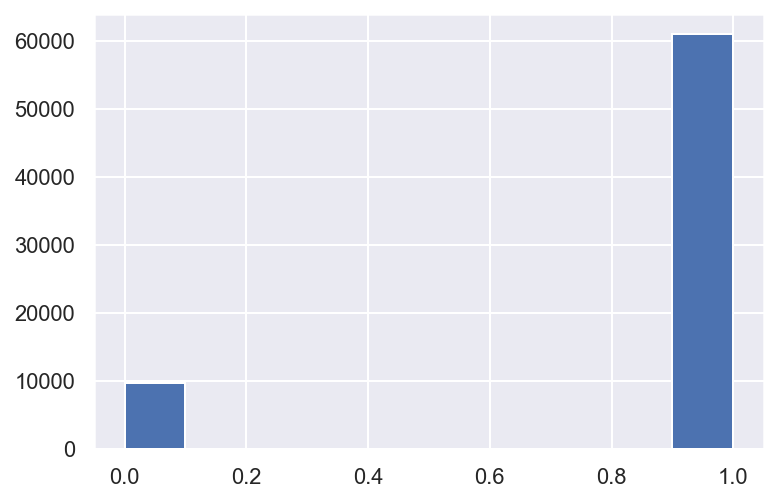

In [97]:
plt.hist(y);

In [101]:
flow, hist_loss = train(x=data['x'], y=data['y'], 
                        r=data['r'], u=data['u'], w=data['w'],
                        n_u=data['n_u'], n_w=data['n_w'],
                        batch_size=40,
                        epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

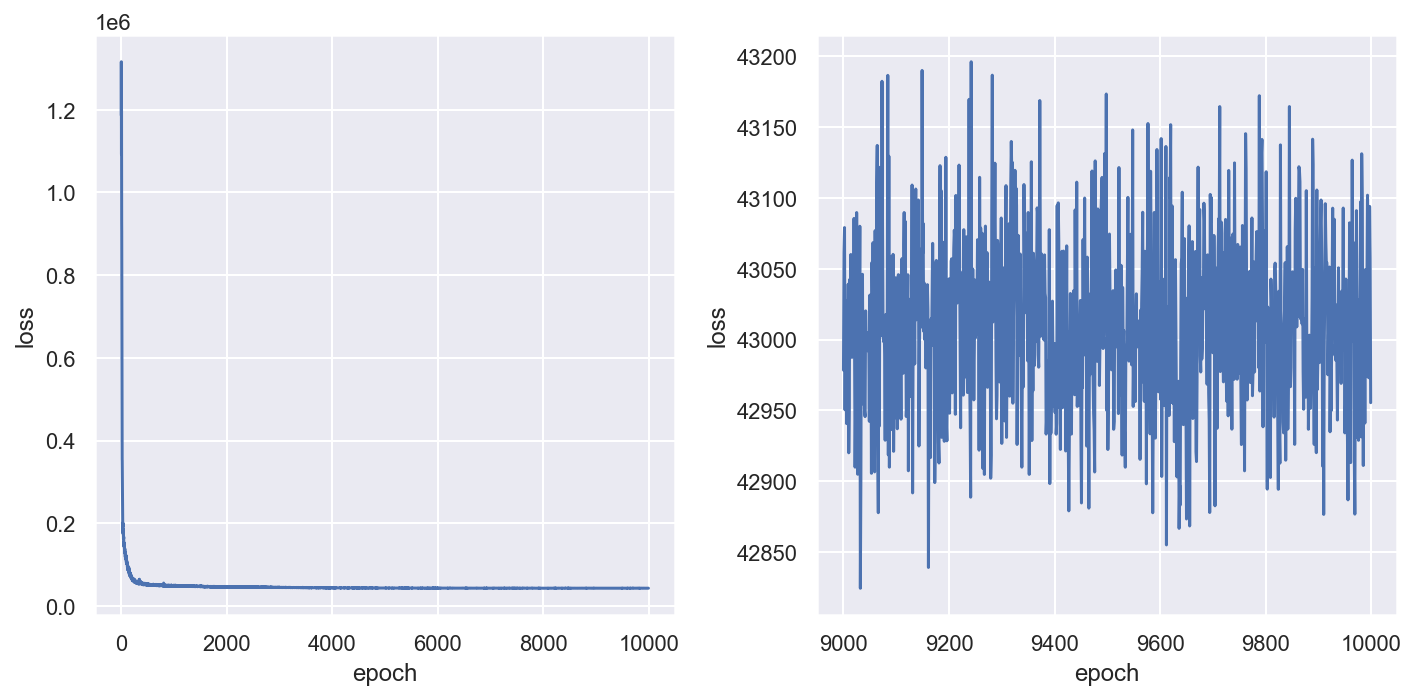

In [134]:
plot_loss(hist_loss, zoom_start=1000)

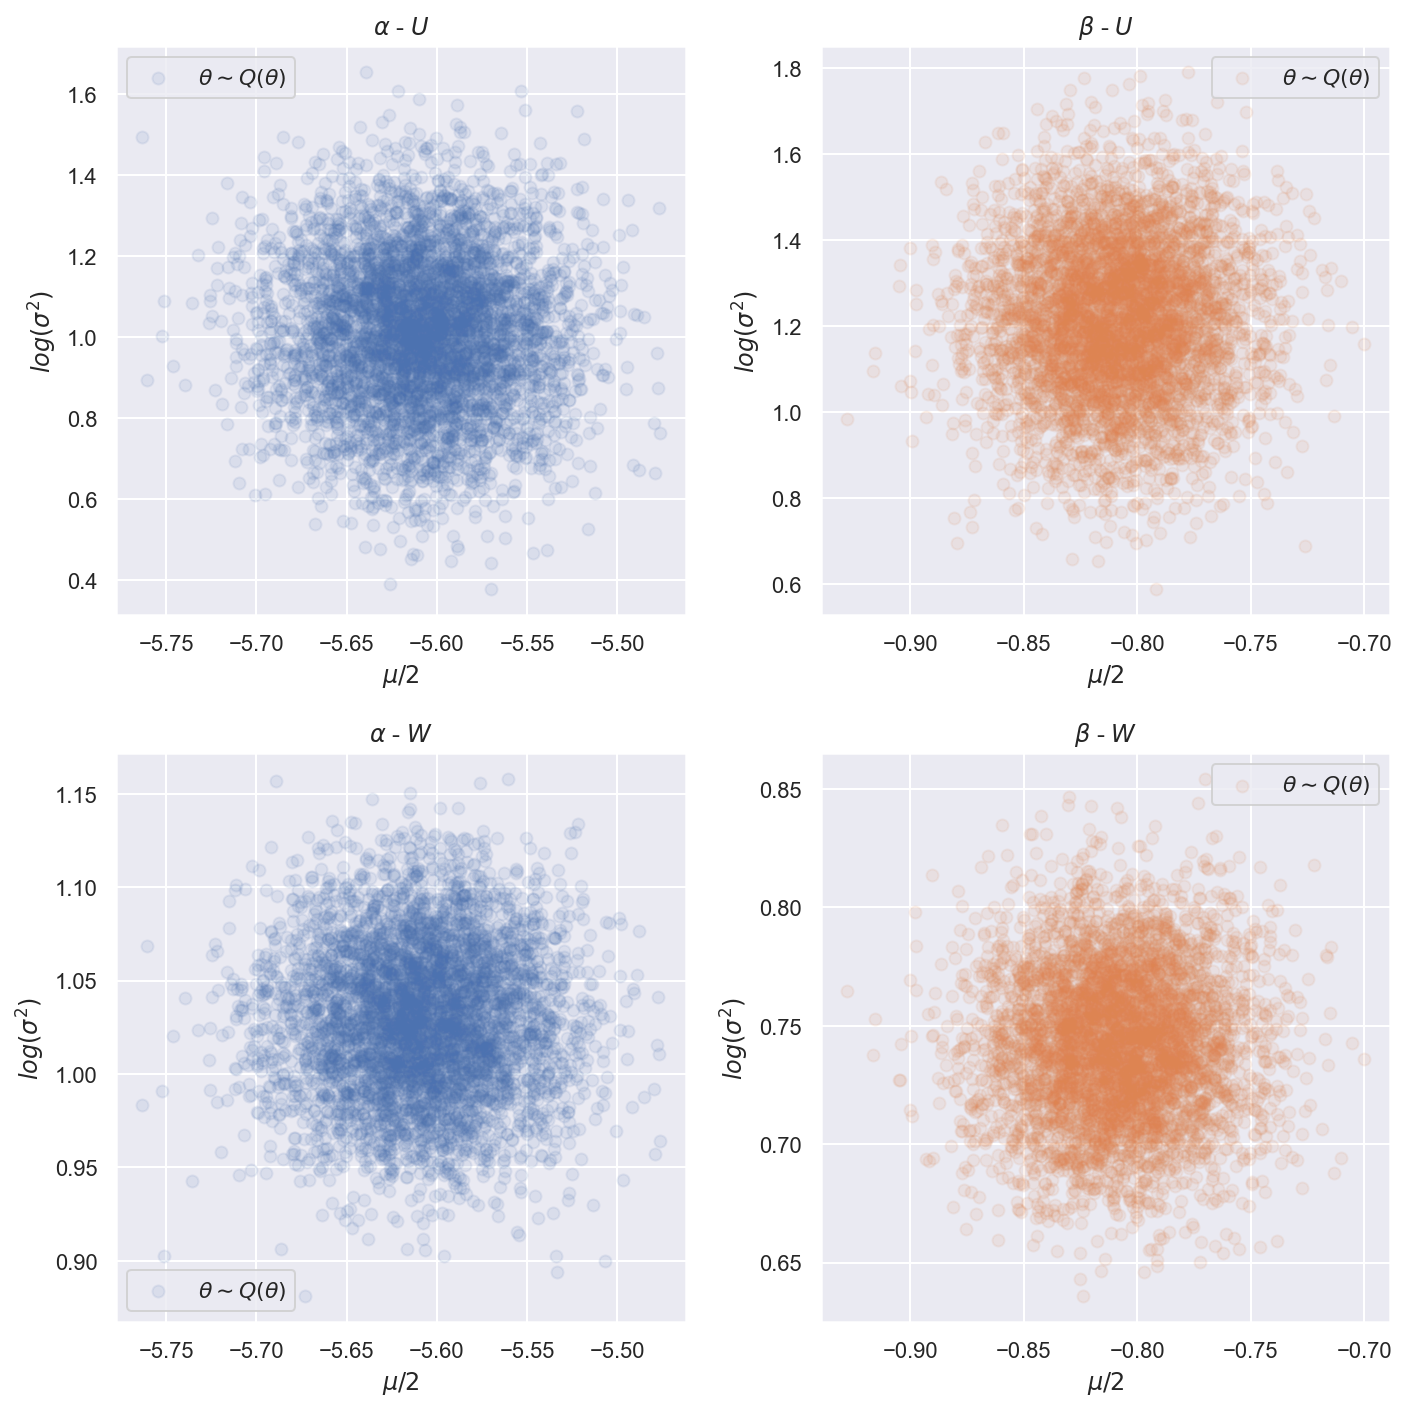

In [135]:
plot_posterior(flow, batch_size=2000)